# Image Retrieval using Embeddings and a Nearest Neighbour search (Planes only)

## Imports

In [1]:
%pip install numpy torch torchvision matplotlib tqdm pillow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from sklearn.manifold import TSNE
from operator import itemgetter
from PIL import Image

## Dataset

### Utils

In [7]:
mean = torch.tensor([0.0812, 0.0764, 0.0727])
std = torch.tensor([0.1789, 0.1699, 0.1633])

batch_size = 128

def get_image_mean_and_std(dataset):
    loader = DataLoader(dataset, batch_size=batch_size)
    numberof_images = 0
    mean, std = 0, 0

    for batch, _, _ in tqdm.tqdm(loader, unit="batch"):
        batch = batch.view(batch.size(0), batch.size(1), -1)

        numberof_images += batch.size(0)
        mean += batch.mean(2).sum(0) 
        std += batch.std(2).sum(0)

    return mean / numberof_images, std / numberof_images

unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

def denorm(x, channels=None, w=None ,h=None, resize=False):
    x = unnormalize(x)
    
    if resize:
        if channels is None or w is None or h is None:
            print('Number of channels, width and height must be provided for resize.')
        x = x.view(x.size(0), channels, w, h)
    
    return x

def show(image, axis=None):
    numpy_image = image.cpu().numpy()
    if axis is not None:
        axis.imshow(np.transpose(numpy_image, (1,2,0)))
    else:
        plt.imshow(np.transpose(numpy_image, (1,2,0)))

transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)                   
])

class ImageFolderWithImagePath(datasets.ImageFolder):
    def __getitem__(self, index):
        data = super().__getitem__(index)
        path = self.imgs[index][0]

        return *data, path

### Load ShapeNet (smaller version for this task)

In [8]:
shapenet_dataset = ImageFolderWithImagePath("ShapeNetReduced/", transform=transform)

In [5]:
mean, std = get_image_mean_and_std(shapenet_dataset)
print(f"Mean: {mean}\nStd. Deviation: {std}")

100%|██████████| 251/251 [00:59<00:00,  4.20batch/s]

Mean: tensor([0.0812, 0.0764, 0.0727])
Std. Deviation: tensor([0.1789, 0.1699, 0.1633])


### Reducing Dataset Size (testing)

In [10]:
shapenet_size = len(shapenet_dataset)
print(f"Size of ShapeNet: {shapenet_size} images.")

shapenet_reduced_size = shapenet_size // 1
unused_shapenet_size = shapenet_size - shapenet_reduced_size
shapenet_reduced_dataset, _ = random_split(shapenet_dataset, (shapenet_reduced_size, unused_shapenet_size))

print(f"Size of reduced ShapeNet: {len(shapenet_reduced_dataset)} images.")

Size of ShapeNet: 32040 images.
Size of reduced ShapeNet: 32040 images.


### Shuffling and Splitting Dataset

In [11]:
ratios = (0.7, 0.1, 0.01, 0.19)

sizes = list(map(lambda x: round(len(shapenet_reduced_dataset) * x), ratios))
if sum(sizes) < len(shapenet_reduced_dataset):
      sizes[0] += len(shapenet_reduced_dataset) - sum(sizes)

print(f"Dataset sizes: {tuple(sizes)}")

[train, test, query, db] = random_split(shapenet_reduced_dataset, sizes)

print(f"Dataset Lengths:"
      f"\n\tTrain: {len(train)},"
      f"\n\tTest: {len(test)},"
      f"\n\tQuery: {len(query)},"
      f"\n\tDatabase: {len(db)}")

loader_train = DataLoader(train, batch_size=batch_size)
loader_test = DataLoader(test, batch_size=batch_size, shuffle=False)
loader_query = DataLoader(query, batch_size=batch_size)
loader_database = DataLoader(db, batch_size=batch_size)

Dataset sizes: (22428, 3204, 320, 6088)
Dataset Lengths:
	Train: 22428,
	Test: 3204,
	Query: 320,
	Database: 6088


## Model

In [12]:
class AutoEncoderModel(nn.Module):
    def __init__(self, latent_size):
        super().__init__()
        
        self.latent_size = latent_size
        self.fc_size = 1024

        self.encoder = nn.Sequential(
            # Input is 64 x 64 x 3, Output is 1 x 1 x 1024
            nn.Conv2d(in_channels=3, out_channels=128, 
                      kernel_size=3, padding=1,
                      stride=2, bias=False), # 32 x 32 x 128
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=256, 
                      kernel_size=3, padding=1,
                      stride=2, bias=False), # 16 x 16 x 256
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=512,
                      kernel_size=3, padding=1,
                      stride=2, bias=False), # 8 x 8 x 512
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512,
                      out_channels=self.fc_size,
                      kernel_size=3, padding=1,
                      stride=2, bias=False), # 4 x 4 x 1024
            nn.BatchNorm2d(self.fc_size),
            nn.AvgPool2d(4), # 1 x 1 x 1024
            nn.ReLU(inplace=True)
        )
        
        self.encoder_mu = nn.Linear(in_features=self.fc_size, 
                                    out_features=self.latent_size)

        self.encoder_var = nn.Linear(in_features=self.fc_size,
                                     out_features=self.latent_size)

        self.decoder_fc = nn.Linear(in_features=self.latent_size, 
                                    out_features=self.fc_size)

        self.decoder = nn.Sequential(
            # Input is 1 x 1 x 1024, Output is 64 x 64 x 3
            nn.ConvTranspose2d(in_channels=self.fc_size,
                               out_channels=self.fc_size,
                               kernel_size=4), # 4 x 4 x 1024
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=self.fc_size,
                               out_channels=512,
                               kernel_size=4, padding=1,
                               stride=2), # 8 x 8 x 512
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=512, out_channels=256,
                               kernel_size=4, padding=1,
                               stride=2), # 16 x 16 x 256
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=256,
                               out_channels=128,
                               kernel_size=4, padding=1,
                               stride=2), # 32 x 32 x 128
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=128,
                               out_channels=3,
                               kernel_size=4, padding=1,
                               stride=2), # 64 x 64 x 3
            nn.Sigmoid()
        )
        
    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)

        mean = self.encoder_mu(x)
        logvar = self.encoder_var(x)

        return mean, logvar
    
    def reparametrize(self, mu, logvar):
        return mu + torch.rand_like(mu).mul(torch.exp(logvar / 2))

    def decode(self, z):
        z = self.decoder_fc(z)
        z = z.view(z.size(0), self.fc_size, 1, 1)
        
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)

        z = mu if not self.training \
            else self.reparametrize(mu, logvar)

        reconstruction = self.decode(z)
        return reconstruction, mu, logvar


## Search Algorithm

In [13]:
def cosine_similarity(a: np.ndarray, b: np.ndarray):
    return float(np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))

def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

def similarity_metric(target, embedding):
    vector, path = embedding
    return cosine_similarity(target, vector), path

def get_closest_match(target_image, embeddings):
    target_image_transformed = target_image.unsqueeze(0).to(device)
    mean, _ = model.encode(target_image_transformed)
    target_embedding = mean.squeeze(0).cpu().detach().numpy()
    
    similarity = map(lambda x: similarity_metric(target_embedding, x), embeddings)
    return sorted(similarity, key=itemgetter(0), reverse=True)

## Training

### Enable CUDA

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda


### Hyperparameters

In [15]:
num_epochs = 20
learning_rate = 1e-4
batch_size = 128
beta = 0.5
image_size = 64
weight_decay = 1e-9
latent_size = 100

### Loss Function

In [16]:
def vae_loss(recon_x, x, mu, logvar, beta):
	x_reshaped = x.view(-1, image_size ** 2)
	recon_x_reshaped = recon_x.view(-1, image_size ** 2)

	loss = F.mse_loss(recon_x_reshaped, x_reshaped, reduction="sum")
	divergence = torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / 2

	return loss - (beta * divergence)

### Initialisation

In [17]:
model = AutoEncoderModel(latent_size).to(device)

optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate, 
                             weight_decay=weight_decay)

### Sample Data

/usr/local/lib/python3.9/dist-packages/torchvision/utils.py:68: UserWarning: The parameter 'range' is deprecated since 0.12 and will be removed in 0.14. Please use 'value_range' instead.
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Dimensions of a batch: torch.Size([128, 3, 64, 64])


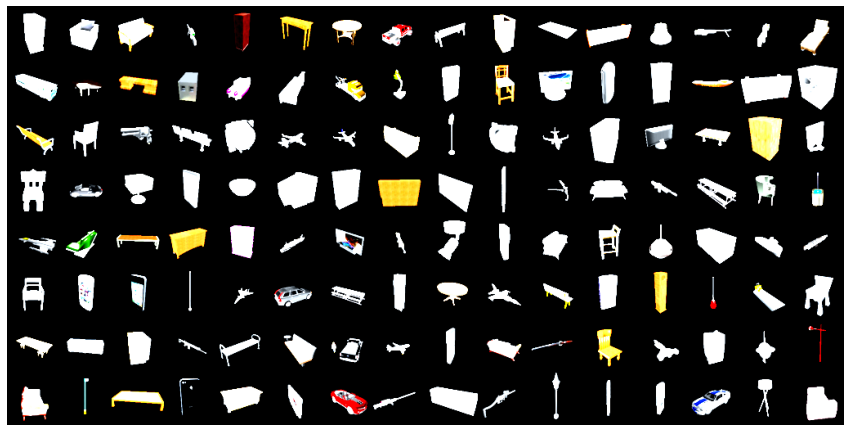

In [18]:
samples, _, _ = next(iter(loader_test))

print(f"Dimensions of a batch: {samples.shape}")

samples = samples.cpu()
samples = make_grid(samples, nrow=16, padding=0, normalize=False,
                    range=None, scale_each=False, pad_value=0)

plt.figure(figsize=(15,15))
plt.axis('off')

show(samples)

### Training Loop

In [19]:
model.train()

epoch_losses = list()

for epoch in range(num_epochs):
	epoch_loss = 0
	num_batches = 0

	with tqdm.tqdm(loader_train, unit="batch") as tepoch: 
		for i, (data, _, _) in enumerate(tepoch):   
			optimiser.zero_grad()
			data = data.to(device)

			reconstruction, mu, logvar = model(data)
			loss = vae_loss(reconstruction, data, mu, logvar, beta)

			loss.backward()
			optimiser.step()

			epoch_loss += loss.item()
			num_batches += 1

			tepoch.set_description(f"Epoch {epoch+1}")
			tepoch.set_postfix(loss=loss.item()/len(data))
	
	epoch_losses.append(epoch_loss / num_batches)

Epoch 20: 100%|██████████| 176/176 [00:27<00:00,  6.43batch/s, loss=8.78e+3]


## Evaluation

In [20]:
model.eval()

AutoEncoderModel(
  (encoder): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): AvgPool2d(kernel_size=4, stride=4, padding=0)
    (12): ReLU(inplace=True)
  )
  (encoder_mu): Linear(in_features=1024, out_features=100, bias=Tru

### Reconstructions

Dimensions of a batch: (128, 3, 64, 64)


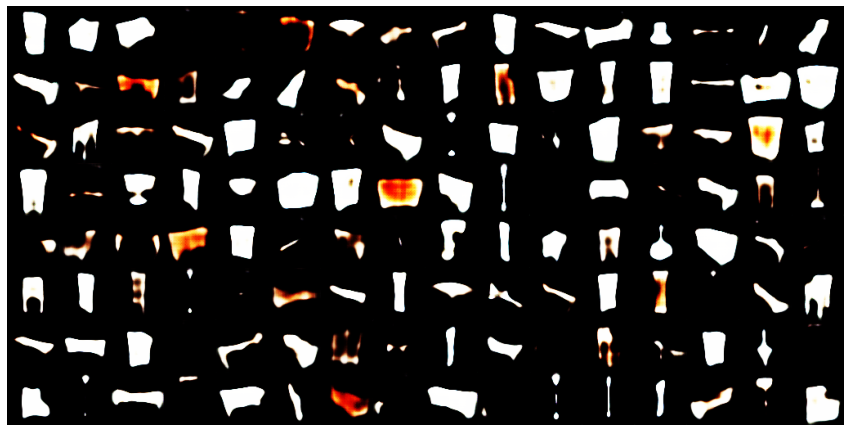

In [21]:
samples, _, _ = next(iter(loader_test))

print(f"Dimensions of a batch: {tuple(samples.shape)}")

reconstruction, _, _ = model(samples.to(device))
reconstruction = make_grid(reconstruction.cpu(), nrow=16, padding=0, 
                           normalize=False, range=None, 
                           scale_each=False, pad_value=0)

plt.figure(figsize=(15,15))
plt.axis('off')

show(reconstruction)

### t-SNE Plot

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


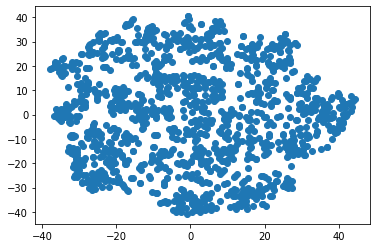

In [22]:
batch_iterable = iter(loader_test)
batches = list()

for _ in range(10):
    images, _, _ = next(batch_iterable)
    mean, _ = model.encode(images.to(device))
    z = mean.cpu().detach().numpy()

    batches.append(z)

z = np.vstack(tuple(batches))

z_reduced = TSNE(init="pca", learning_rate="auto").fit_transform(z)
z_reduced_x, z_reduced_y = zip(*z_reduced)

figure, axis = plt.subplots()

axis.scatter(list(z_reduced_x), list(z_reduced_y))

## Query Test

### Create Embeddings Database

In [23]:
loader_database = DataLoader(db, batch_size=batch_size, shuffle=False)

embeddings_database = list()

for images, _, paths in tqdm.tqdm(loader_database, unit="batch"):
    mu, _ = model.encode(images.to(device))
    embeddings = mu.cpu().detach().numpy()
    embeddings_database.extend(list(zip(embeddings, paths)))

100%|██████████| 48/48 [00:35<00:00,  1.37batch/s]


In [24]:
test_embedding, test_path = embeddings_database[0]
print(test_embedding.shape, test_path)

(100,) ShapeNetReduced/04256520/17b1927dbf59786a45b09d36414f81ec/rendering/06.png


### Run Query

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Similarity (image 1): 0.9220826625823975
Similarity (image 2): 0.9215021133422852
Similarity (image 3): 0.8858546614646912
Similarity (image 4): 0.8735581040382385
Similarity (image 5): 0.7890141606330872


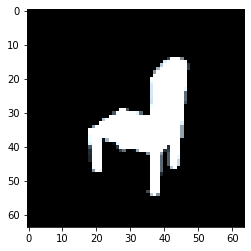

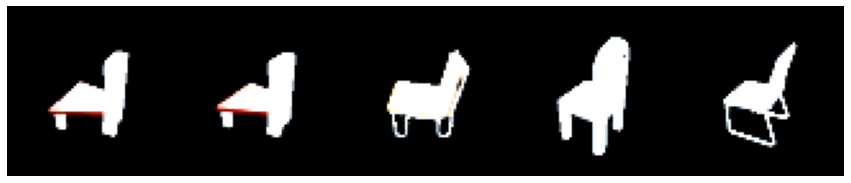

In [26]:
target, _, _ = random.choice(loader_query.dataset)
results = get_closest_match(target, embeddings_database)

figure, axis = plt.subplots()
show(target, axis=axis)

samples = list()

for i, (similarity, path) in enumerate(results[:5]):
    print(f"Similarity (image {i+1}): {similarity}")
    image = Image.open(path, ).convert("RGB")
    samples.append(transform(image).unsqueeze(0).cpu())

samples = torch.vstack(samples)
samples = make_grid(samples, nrow=5, padding=1, normalize=False,
                    range=None, scale_each=False, pad_value=0)

plt.figure(figsize=(15,15))
plt.axis('off')

show(samples)